# Classifying Chest X-rays

I've combined most of the things I've learnt so far in this classification problem using data I found at:

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

With 5856 images the dataset is rather small. But considering computational time I thought this would be a starting point. I implemented a neural network for binary classification into categories: normal and pneumonia. 

### Some imports

In [154]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

### Splitting data into train/validation/test sets

The original dataset was split into train, val and test folders with 5216 training images, 16 validation images and 624 test images. Each folder was further split into NORMAL and PNEUMONIA folders. Since 16 images in the validation set is abnormally little, I manually put all images into one folder (with normal and pneumonia subfolders), and then loaded the data and randomly divided it into train/val/test in the ratio 0.64/0.16/0.2 using the following:

In [155]:
data_dir = '∽\\Chest_Xray\\Xray_images'

source_path = data_dir + '\\source'
destination_path = data_dir + '\\destination'


import split_folders

split_folders.ratio(source_path, output=destination_path, seed=12, 
                    ratio=(.64, .16, .2)) 






Copying files: 0 files [00:00, ? files/s]




Copying files: 10 files [00:00, 98.09 files/s]




Copying files: 54 files [00:00, 127.81 files/s]




Copying files: 97 files [00:00, 161.77 files/s]




Copying files: 137 files [00:00, 196.64 files/s]




Copying files: 178 files [00:00, 232.29 files/s]




Copying files: 222 files [00:00, 269.63 files/s]




Copying files: 265 files [00:00, 302.34 files/s]




Copying files: 310 files [00:00, 334.62 files/s]




Copying files: 353 files [00:00, 356.72 files/s]




Copying files: 395 files [00:01, 371.67 files/s]




Copying files: 436 files [00:01, 380.30 files/s]




Copying files: 477 files [00:01, 381.20 files/s]




Copying files: 517 files [00:01, 370.57 files/s]




Copying files: 556 files [00:01, 359.58 files/s]




Copying files: 593 files [00:01, 359.51 files/s]




Copying files: 630 files [00:01, 354.29 files/s]




Copying files: 666 files [00:01, 354.97 files/s]




Copying files: 707 files [00:01, 368.90 files/s]





Copying files: 4825 files [00:26, 84.15 files/s]




Copying files: 4844 files [00:26, 91.70 files/s]




Copying files: 4865 files [00:27, 61.81 files/s]




Copying files: 4875 files [00:27, 53.50 files/s]




Copying files: 4910 files [00:27, 71.65 files/s]




Copying files: 4960 files [00:27, 96.17 files/s]




Copying files: 5000 files [00:27, 124.32 files/s]




Copying files: 5041 files [00:27, 156.82 files/s]




Copying files: 5076 files [00:27, 187.81 files/s]




Copying files: 5120 files [00:28, 226.47 files/s]




Copying files: 5157 files [00:28, 247.60 files/s]




Copying files: 5198 files [00:28, 280.46 files/s]




Copying files: 5244 files [00:28, 316.37 files/s]




Copying files: 5284 files [00:28, 326.01 files/s]




Copying files: 5331 files [00:28, 358.21 files/s]




Copying files: 5380 files [00:28, 277.35 files/s]




Copying files: 5414 files [00:29, 222.81 files/s]




Copying files: 5443 files [00:29, 232.69 files/s]




Copying files: 5471 files [00:29, 

Setting the paths for train/val/test and counting number of images to check:

In [156]:
train_path = destination_path + '\\train'
val_path = destination_path + '\\val'
test_path = destination_path + '\\test'

train_normal_count = len(os.listdir(train_path + '\\NORMAL'))
train_pneumonia_count = len(os.listdir(train_path + '\\PNEUMONIA'))
train_count = train_normal_count + train_pneumonia_count
print('Train count: ' + str(train_count))

val_normal_count = len(os.listdir(val_path + '\\NORMAL'))
val_pneumonia_count = len(os.listdir(val_path + '\\PNEUMONIA'))
val_count = val_normal_count + val_pneumonia_count
print('Validation count: ' + str(val_count))

test_normal_count = len(os.listdir(test_path + '\\NORMAL'))
test_pneumonia_count = len(os.listdir(test_path + '\\PNEUMONIA'))
test_count = test_normal_count + test_pneumonia_count
print('Test count: ' + str(test_count))

Train count: 3747
Validation count: 936
Test count: 1173


### Visualising a few of the images

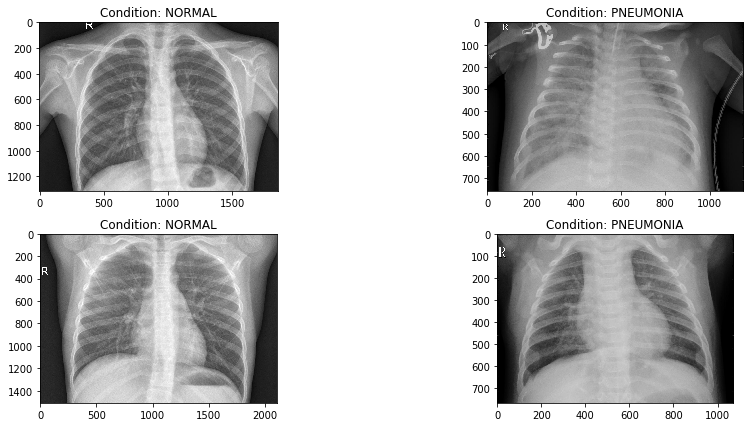

In [157]:
fig, ax = plt.subplots(2,2 , figsize=(15, 7), gridspec_kw={'hspace': 0.25})
ax = ax.ravel()

for i, folder in enumerate(['NORMAL', 'PNEUMONIA']):
    for n in range(1):
        img_path = train_path+ '\\' + folder
        ax[i].imshow(plt.imread(img_path+ '\\'+os.listdir(img_path)[n]), cmap='gray')
        ax[i].set_title('Condition: {}'. format(folder))
        ax[i+2].imshow(plt.imread(img_path+ '\\'+os.listdir(img_path)[n+1]), cmap='gray')
        ax[i+2].set_title('Condition: {}'. format(folder))

### Preparing data

Defining constants for later use:

In [158]:
batch_size = 32
epochs = 20
image_shape = (256, 256, 3) #the images were on average more than 1000x1000 
                            #so I reduced the size enough so that my computer
                            #could handle it

Rescaling the images so that they're normalised and since I'm working with a small dataset, I augmented the training data. However, this was done rather caustiously since real chest X-ray images don't have much variation.

In [159]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1/255,
                               rotation_range=10, 
                               width_shift_range=0.05, 
                               height_shift_range=0.05, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=False, # All X-rays are taken from the front
                               fill_mode='nearest' 
                              )

val_gen = ImageDataGenerator(rescale=1/255)

Creating generators so that data can be fed into network from the data directories

In [160]:
train_image_gen = train_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')


val_image_gen = val_gen.flow_from_directory(val_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 3747 images belonging to 2 classes.
Found 936 images belonging to 2 classes.


Checking the indices for the two classes:

In [161]:
train_image_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Having a look whether the dataset is balanced:

In [162]:
counts = {'Category':['NORMAL', 'PNEUMONIA'], 'Number of images':[train_normal_count, train_pneumonia_count]}
counts_df = pd.DataFrame(counts)
counts_df

,Category,Number of images
0,NORMAL,1013
1,PNEUMONIA,2734


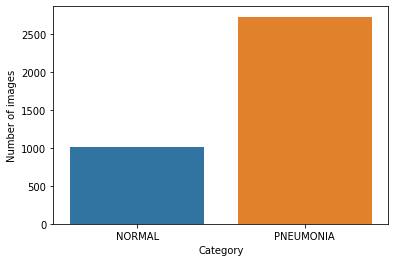

In [163]:
sns.barplot(x='Category', y='Number of images', data=counts_df)

To overcome the data imbalance, normal images were weighted more.
This was inspired by https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays/

In [164]:
weight_for_0 = (1 / train_normal_count)*(train_count)/2.0 
weight_for_1 = (1 / train_pneumonia_count)*(train_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (Normal): ' + str("%.3f" % weight_for_0))
print('Weight for class 1 (Pneumonia): ' + str("%.3f" % weight_for_1))

Weight for class 0 (Normal): 1.849
Weight for class 1 (Pneumonia): 0.685


### Building the network

In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, SeparableConv2D


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, 
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(SeparableConv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(SeparableConv2D(filters=128, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))


model.add(Dense(1, activation='sigmoid'))

from tensorflow.keras.metrics import Precision, Recall

METRICS = [
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall')
            ]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 126, 126, 64)      2400      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 61, 61, 128)       8896      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)           

Adding callbacks:

Earlystopping to prevent overfitting and prevent "waste" of time (I set a high patience since the validation loss tended to fluctuate quite a lot at the begining of my previous tries)

ReduceLROnPlateau to reduce learning rate once val_loss isn't improving over 2 epochs

ModelCheckpoint saving the best weights if needed later

In [166]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss',patience=6, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
checkpoint = ModelCheckpoint(filepath='xxx_best_weights.hdf5', save_best_only=True, save_weights_only=True)

In [ ]:
results = model.fit_generator(train_image_gen,epochs=epochs, verbose=1,
                              validation_data=val_image_gen, class_weight=class_weight, callbacks=[early_stop, lr_reduce, checkpoint]

In [ ]:
model.save('xxx.h5')
hist_csv_file = 'xxx_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Evaluating the model

I've already trained the model so I'll just load the saved final model and it's history here. 

In [167]:
from tensorflow.keras.models import load_model

my_model = load_model('final_model.h5')
history_df = pd.read_csv('final_history.csv')

In [168]:
history_df

,Unnamed: 0,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr
0,0,0.653149,0.649586,0.770667,0.739941,0.328710,0.854701,0.982363,0.815520,0.001000
1,1,0.329382,0.869496,0.953535,0.863204,0.286478,0.894231,0.986667,0.866764,0.001000
2,2,0.264745,0.898052,0.963357,0.894294,0.203933,0.925214,0.976672,0.919473,0.001000
3,3,0.217516,0.922605,0.968199,0.924287,0.217540,0.913462,0.987055,0.893119,0.000300
4,4,0.207665,0.921270,0.969942,0.920629,0.216722,0.915598,0.985531,0.897511,0.000300
5,5,0.203893,0.926341,0.971966,0.925750,0.205720,0.922009,0.985669,0.906296,0.000090
6,6,0.189563,0.933013,0.976583,0.930505,0.176030,0.935897,0.984448,0.926794,0.000090
7,7,0.186749,0.934881,0.974105,0.935625,0.229503,0.911325,0.987013,0.890190,0.000027
8,8,0.191018,0.931946,0.976547,0.929042,0.181041,0.938034,0.986003,0.928258,0.000027
9,9,0.194889,0.929811,0.972467,0.930139,0.188699,0.934829,0.985937,0.923865,0.000008


Plotting graphs for metrics: 

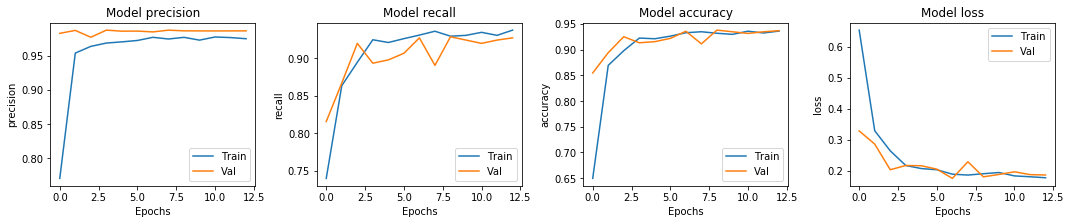

In [179]:
fig, ax = plt.subplots(1, 4, figsize=(18, 3), gridspec_kw={'wspace': 0.3})
ax = ax.ravel()

for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_df[metric])
    ax[i].plot(history_df['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['Train', 'Val'])

 
 
Evaluating on the test dataset:

In [180]:
test_gen = ImageDataGenerator(rescale=1/255)

test_image_gen = test_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

loss, accuracy, precision, recall = my_model.evaluate(test_image_gen)

Found 1173 images belonging to 2 classes.
37/37 [==============================] - 30s 815ms/step - loss: 0.1530 - accuracy: 0.9471 - precision: 0.9806 - recall: 0.9463


Generating classification report and confusion matrix

In [181]:
pred_probabilities = my_model.predict_generator(test_image_gen)
predictions = pred_probabilities > 0.5


from sklearn.metrics import classification_report,confusion_matrix
print('Classification report: \n' + classification_report(test_image_gen.classes,predictions))

print('Confusion matrix: ')
conf_mat = confusion_matrix(test_image_gen.classes,predictions)
print(conf_mat)
print('True negatives: ' + str(conf_mat[0,0]))
print('False negatives: ' + str(conf_mat[1,0]))
print('False positives: ' + str(conf_mat[0,1]))
print('True positives: ' + str(conf_mat[1,1]))

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       317
           1       0.98      0.95      0.96       856

    accuracy                           0.95      1173
   macro avg       0.92      0.95      0.93      1173
weighted avg       0.95      0.95      0.95      1173

Confusion matrix: 
[[301  16]
 [ 46 810]]
True negatives: 301
False negatives: 46
False positives: 16
True positives: 810


Predicting on an example image:

Predicted category: Pneumonia


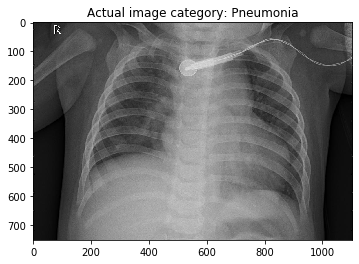

In [182]:
# selecting an image:

image_category = 'Pneumonia'      #Normal or Pneumonia
image_number = 800                #0-316 for Normal, 0-855 for pneumonia


# showing selected image with title giving its actual category
img_category_folder = '\\' + image_category + '\\'

example_image_path = test_path+ img_category_folder +os.listdir(test_path+ img_category_folder)[image_number]
ex_img = plt.imread(example_image_path)
plt.imshow(ex_img, cmap='gray')
plt.title('Actual image category: ' + image_category)


# feeding selected image into model
from tensorflow.keras.preprocessing import image
example_image = image.load_img(example_image_path, target_size=image_shape).convert('RGB') 
#visualising grayscale below but model is trained for RGB as there are some images in dataset that are RGB
example_image = image.img_to_array(example_image)
example_image = np.expand_dims(example_image, axis=0)
prediction = my_model.predict(example_image)

# printing the category predicted by model
def pred_category(p):
    if (p)[0]==0:
        pred = 'Normal'
        
    elif p[0] ==1:
        pred ='Pneumonia'
        
    return pred

print('Predicted category: ' + pred_category(prediction))
    

### Conclusion

The model in this notebook is the best one I managed to achieve after roughly 25 different training runs, with adjustment of parameters the neural network architecture between each run.

Since the dataset was imbalanced, a high accuracy (around 75%) would be expected from predicting only 'Pneumonia' alone. But the achieved 94.7% accuracy is considerably higher than that and the performance of this model is therefore quite good.

The weighting of the two different classes also helped, achieving a precision that's higher than recall. 

I managed to avoid overfitting, but since the validation accuracy seemed to be slightly higher than the training accuracy most of the time, it would suggest underfitting. However, adding more layers and making the network deeper only seemed to result in the model not being trained at all and I could not find an answer to this issue.

Now I realise, I could extend this model to further classify the pneumonia as either bacterial or viral and I should perhaps have found a larger dataset for categorical classification or something suitable for predicting a continuous variable. Although, I didn't do that now since I was worried about computational time. I will set things up on another computer with greater computational power and it will hopefully leave me with more time to try out different neural network architectures and allow me to work with larger datasets.

Being quite new to all of this I also want to work on making my code look 'neater'.

I'll greatly appreciate any tips or suggestions for improvement!